Random Forest makes prediction based on individual outputs of many decision trees. The goal is to improve upon the original foreast that used a single decision tree and achieved an accuracy around 0.934.

In [35]:
import pandas as pd

In [36]:
#Read the data
X_train = pd.read_csv('X_train_w_ID.csv', index_col=0)
X_test = pd.read_csv('X_test_w_ID.csv', index_col = 0)
Y_train = pd.read_csv('Y_train.csv', index_col = 0, header= None, names = ['Y'])
Y_test = pd.read_csv('Y_test.csv', index_col = 0, header= None, names = ['Y'])

In [37]:
#Remove patient ID from the training data
x_train = X_train.drop("DESYNPUF_ID",axis=1)

In [38]:
x_train.shape[0]

83270

In [56]:
x_test.shape[1]

27

In [40]:
#Remove patient ID from testing set
x_test = X_test.drop('DESYNPUF_ID',axis=1)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Build a random forest using 100 estimators for testing purposes
rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_def = rf_def.fit(x_train, Y_train)
rf_pred = rf_def.predict_proba(x_test)


/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [42]:
# Function to print ROC curves. 
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

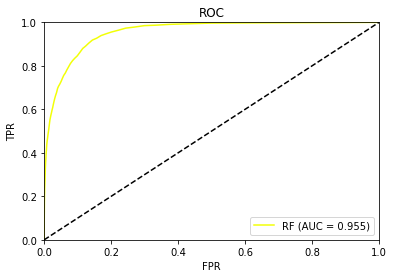

In [43]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

plotUnivariateROC(rf_pred[:,1], Y_test, 'RF')
plt.show()

A simple Random Forest already outperformed the original decision tree forecast by producing an AUC of 0.953.

Next I will use use out-of-bag error to tune parameters for the random forest and further improve accuracy.

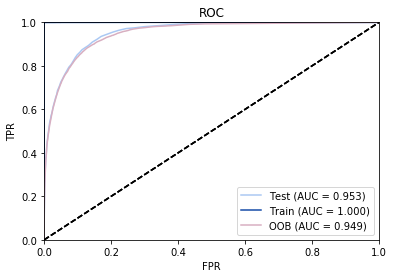

In [44]:
#This is just to show that OOB method produces similar results 
rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100, oob_score=True)
rf_def = rf_def.fit(x_train, Y_train.values.ravel())
rf_pred_test = rf_def.predict_proba(x_test)
rf_pred_train = rf_def.predict_proba(x_train)

plotUnivariateROC(rf_pred_test[:,1], Y_test, 'Test')
plotUnivariateROC( rf_pred_train[:,1],Y_train, 'Train')
plotUnivariateROC(rf_def.oob_decision_function_[:,1], Y_train, 'OOB')
plt.show()

Now use OOB to perform model selection.

In [45]:
#Select different estimator sizes and number of features
n_est = [50, 100, 200, 500, 1000]
m_feat = [1, 3, 6, 11]

aucs_oob = {}
aucs_test = {}

for m in m_feat:
    aucs_oob[m] = []
    aucs_test[m] = []
    for n in n_est:
        rf_oob = RandomForestClassifier(criterion='entropy', n_estimators=n, max_features=m, oob_score=True)
        rf_oob = rf_oob.fit(x_train, Y_train.values.ravel())
        aucs_oob[m].append(roc_auc_score(Y_train, rf_oob.oob_decision_function_[:,1]))
        aucs_test[m].append(roc_auc_score(Y_test, rf_oob.predict_proba(x_test)[:,1]))

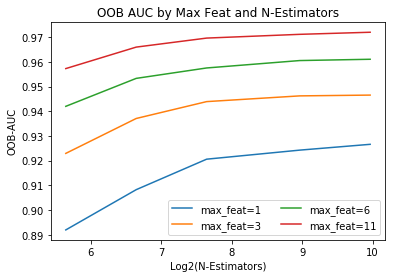

In [46]:
#Plot results

x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_oob[m], label='max_feat={}'.format(m))
    
plt.title('OOB AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('OOB-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

And model with 11 max features and 1000 estimators produced the highest accuracy.

Based on the chart, further increasing number of estimators might slowly continue improving the results, but the improvement may be only marginal. On the other hand, increasing number of features may be more promising.

In [47]:
#Build a random forest with 12 max features and 1000 estimators.
big_rf = RandomForestClassifier(criterion='entropy', max_features = 12, n_estimators=1000)
big_rf = big_rf.fit(x_train, Y_train.values.ravel())

In [48]:
#Calculate accuracy and recall
from sklearn import metrics

#Predicting train_df
fcst_train = big_rf.predict(x_train)

#Predicting test_df
fcst_test = big_rf.predict(x_test)

train_accuracy = big_rf.score(x_train, Y_train)
test_accuracy = big_rf.score(x_test, Y_test)

train_recall = metrics.recall_score(Y_train, fcst_train)
test_recall = metrics.recall_score(Y_test, fcst_test)

print('Train accuracy:',train_accuracy, '\nTest accuracy:', test_accuracy, '\nDifference:', 
     train_accuracy - test_accuracy)

print('\nTrain recall: ', train_recall, '\nTest recall: ', test_recall, '\nDifference: ', train_recall-test_recall)

Train accuracy: 0.999951963492 
Test accuracy: 0.948409410239 
Difference: 0.0515425532534

Train recall:  0.999536446865 
Test recall:  0.572705397044 
Difference:  0.426831049822


In [49]:
sample_weight = np.array([1 if i == 0 else 9 for i in Y_train.values])

sample_weight

array([1, 1, 1, ..., 1, 1, 1])

The Recall performance was below the simple Decision Tree we tested previously which produced a 70% recall. Now I'll retrain the Random Forest to determine the best parameters for maximizing Recall instead of accuracy.

I'll also try rebalancing classes to reflect on higher prevalence of negative target in the dataset for improving Recall.

In [50]:
#Select different estimator sizes and number of features
n_est = [50, 100, 200, 500, 1000]
m_feat = [1, 3, 6, 11]

recall_oob = {}
recall_test = {}

sample_weight = np.array([1 if i == 0 else 9 for i in Y_train.values])

for m in m_feat:
    recall_oob[m] = []
    recall_test[m] = []
    for n in n_est:
        rf_oob = RandomForestClassifier(criterion='entropy', n_estimators=n, max_features=m, oob_score=True)
        rf_oob = rf_oob.fit(x_train, Y_train.values.ravel(), sample_weight=sample_weight)
        recall_oob[m].append(metrics.recall_score(Y_train, rf_oob.predict(x_train)))
        recall_test[m].append(metrics.recall_score(Y_test, rf_oob.predict(x_test)))

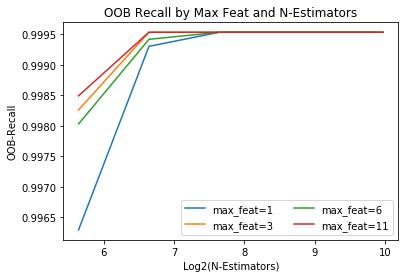

In [51]:
#Plot results

x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, recall_oob[m], label='max_feat={}'.format(m))
    
plt.title('OOB Recall by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('OOB-Recall')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

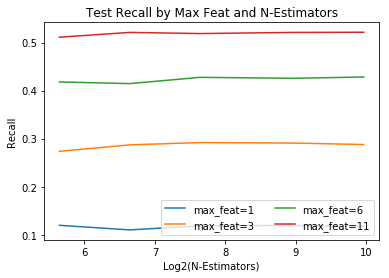

In [52]:
x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, recall_test[m], label='max_feat={}'.format(m))
    
plt.title('Test Recall by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('Recall')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

In [53]:
#Build a random forest based on the parameter tuning above
big_rf = RandomForestClassifier(criterion='entropy', max_features = None, n_estimators=100)
big_rf = big_rf.fit(x_train, Y_train.values.ravel())

In [54]:
#Calculate accuracy and recall
from sklearn import metrics

#Predicting train_df
fcst_train = big_rf.predict(x_train)

#Predicting test_df
fcst_test = big_rf.predict(x_test)

train_accuracy = big_rf.score(x_train, Y_train)
test_accuracy = big_rf.score(x_test, Y_test)

train_recall = metrics.recall_score(Y_train, fcst_train)
test_recall = metrics.recall_score(Y_test, fcst_test)

print('Train accuracy:',train_accuracy, '\nTest accuracy:', test_accuracy, '\nDifference:', 
     train_accuracy - test_accuracy)

print('\nTrain recall: ', train_recall, '\nTest recall: ', test_recall, '\nDifference: ', train_recall-test_recall)

Train accuracy: 0.999927945238 
Test accuracy: 0.959181467738 
Difference: 0.0407464775005

Train recall:  0.999304670298 
Test recall:  0.675833619801 
Difference:  0.323471050497


Setting max_teatures to None improved recall. I will perform grid search next to further tune the parameters.

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', max_features= 'sqrt', n_estimators=200, oob_score = True) 

param_grid = { 
    'max_depth' : [30, 100, None],
    'n_estimators': [10, 20, 50, 200],
    'max_features': [None, 10, 20, 'auto'],
    'min_samples_leaf' : [2, 50, 100]   
}

CV_rfc = GridSearchCV(estimator=rfc, scoring='recall', param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, Y_train.values.ravel())

print(CV_rfc.best_params_)

/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/sklearn

In [71]:
#Build a random forest based on the parameter tuning above
rf = RandomForestClassifier(criterion='entropy', max_features = None, n_estimators=50, min_samples_leaf=2)
rf = rf.fit(x_train, Y_train.values.ravel())

In [75]:
#Calculate accuracy and recall
from sklearn import metrics

#Predicting train_df
fcst_train = rf.predict(x_train)

#Predicting test_df
fcst_test = rf.predict(x_test)

train_accuracy = rf.score(x_train, Y_train)
test_accuracy = rf.score(x_test, Y_test)

train_recall = metrics.recall_score(Y_train, fcst_train)
test_recall = metrics.recall_score(Y_test, fcst_test)

train_precision = metrics.precision_score(Y_train, fcst_train)
test_precision = metrics.precision_score(Y_test, fcst_test)

test_auc = roc_auc_score(Y_test, rf.predict_proba(x_test)[:,1])

print('Train accuracy:',train_accuracy, '\nTest accuracy:', test_accuracy, '\nDifference:', 
     train_accuracy - test_accuracy)

print('\nTrain recall: ', train_recall, '\nTest recall: ', test_recall, '\nDifference: ', train_recall-test_recall)

print('\nTrain precision:',train_precision, '\nTest precision:', test_precision, '\nDifference:', 
     train_precision - test_precision)

print('\nTest AUC: ', test_auc)



Train accuracy: 0.998186621833 
Test accuracy: 0.958424901827 
Difference: 0.039761720006

Train recall:  0.983427975432 
Test recall:  0.669645926435 
Difference:  0.313782048996

Train precision: 0.9990581587 
Test precision: 0.909855207847 
Difference: 0.0892029508535

Test AUC:  0.980369916884


In [69]:
test_precision = metrics.precision_score(Y_test, fcst_test)
print(test_precision)

0.914804469274


In [ ]:
#Visualize feature importance
import matplotlib.pyplot as plt
%matplotlib inline

importances = rf.feature_importances_
#print(len(importances))

labels = x_train.columns

assert(len(importances) == len(labels))

print(importances)

#Sort and order importances in descending order
importances.sort()
importances = importances[::-1]

N = len(importances)
xx = np.linspace(0, 1, N)
plt.figure(figsize=(20,10))
plt.bar(xx, importances, width=1/N/1.5)
plt.xticks(xx, labels, rotation='vertical')
plt.title('Features by importance')

plt.grid(True)

In [ ]:
#Function to visualize classification
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', max_features = None, n_estimators=50, min_samples_leaf=2)
X = x_train[['unique_ip_dt_mm', '#Rx_mm']].as_matrix()
y = Y_train.as_matrix()



In [ ]:
x_test.columns

In [ ]:
visualize_classifier(rf, X, y)